# Conect4 AI

How does the Conect4 AI works ?

## 0 - Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pettingzoo.classic import connect_four_v3
from networkx import from_dict_of_dicts, draw, draw_networkx_edge_labels
from collections import Counter
from tqdm import tqdm

from drawtree import hierarchy_pos
from mcts import MCTSPlayer
from agent import RandomPlayer, UserPlayer
from play import play_game

## 1 - Play one game

In [2]:
env = connect_four_v3.env(render_mode="rgb_array")
env.reset()

# The first player is usually called "player" while the other is called "other".

##########################
# !!!!!!! WARNING !!!!!! #
##########################
# Be careful to correctly number the players (the first is numbered 0 and the second 1)
# elsewhere the game is not going to work

player = MCTSPlayer(number=0, name="MCTS Player 0", n_rollout=10000)
# player = RandomPlayer(number=0, name="Random Player 0")
# player = UserPlayer(number=0, name="User 0")

# other = MCTSPlayer(number=1, name="MCTS Player 1", n_rollout=5000)
# other = RandomPlayer(number=1, name="Random Player 1")
other = UserPlayer(number=1, name="User 1")

Play this cell until the game is finished. Have fun !

In [41]:
state, reward, terminated, _, _ = env.last()

if terminated:
    if reward == 0:
        print("Draw, congratulations to both players")
    else:
        print(f"{other.name} won ! Congratulations !!!")

else:
    action = player.get_action(env)
    env.step(action)
    player, other = other, player
    plt.imshow(env.render())
    plt.axis("off")
    plt.show()

User 1 won ! Congratulations !!!


## 2 - Agents competition

In [48]:
env = connect_four_v3.env(render_mode="rgb_array")

wins = []
rounds = []
n_games = 100
for _ in tqdm(range(n_games), desc="Games played", total=n_games):
    # player = MCTSPlayer(number=0, name="MCTS Player 0", n_rollout=2000)
    other = MCTSPlayer(number=1, name="MCTS Player 1", n_rollout=2000)

    player = RandomPlayer("Random Player 0", 0)
    # other = RandomPlayer("Random Player 1", 1)

    winner, n_rounds = play_game(env, player, other)

    wins.append(winner)
    rounds.append(n_rounds)

Games played: 100%|██████████| 100/100 [31:46<00:00, 19.07s/it]


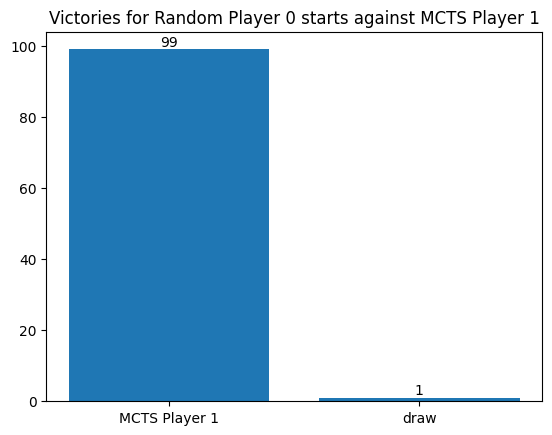

In [52]:
count = Counter(wins)
winners = count.keys()
nb = [count[winner] for winner in winners]
bars = plt.bar(winners, nb)
plt.title(f"Victories for {player.name} starts against {other.name}")
plt.bar_label(bars, label_type="edge")
plt.show()

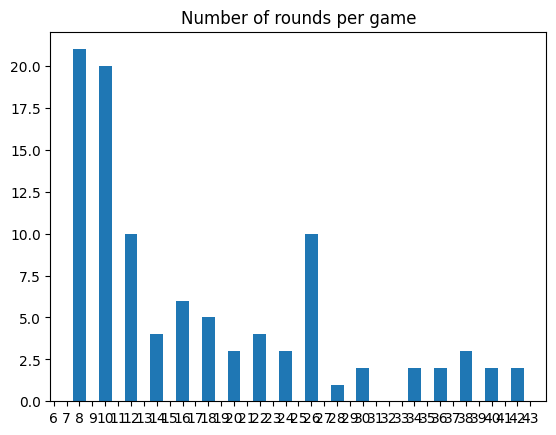

In [51]:
plt.hist(rounds, bins=(max(rounds) - min(rounds)+1), range=(min(rounds) - 0.5, max(rounds) + 0.5))
plt.title("Number of rounds per game")
plt.xticks(np.arange(min(rounds)-2, max(rounds)+2))
plt.show()

## 3 - Some Agents inspection

### MCTS Tree

To see the MCTS Agent tree, let's create an environment and an agent and ask him an action to create its tree

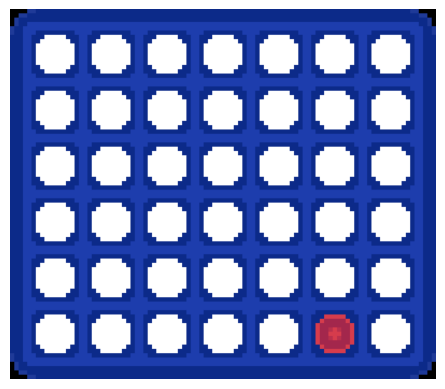

In [32]:
env = connect_four_v3.env(render_mode="rgb_array")
env.reset()

agent = MCTSPlayer(number=0, n_rollout=500)
action = agent.get_action(env)

env.step(action)

plt.axis("off")
plt.imshow(env.render())
plt.show()

Then let's create a dict of dicts containing the nodes and their children

In [33]:
child_dict = {}
queue = [agent.root.parent]
while len(queue) > 0:
    node = queue.pop(0)
    child_dict[node] = {child: {"weight": action} for action, child in node.children.items()}
    for child in node.children.values():
        queue.append(child)

Finally let's display the nodes graph with their weights

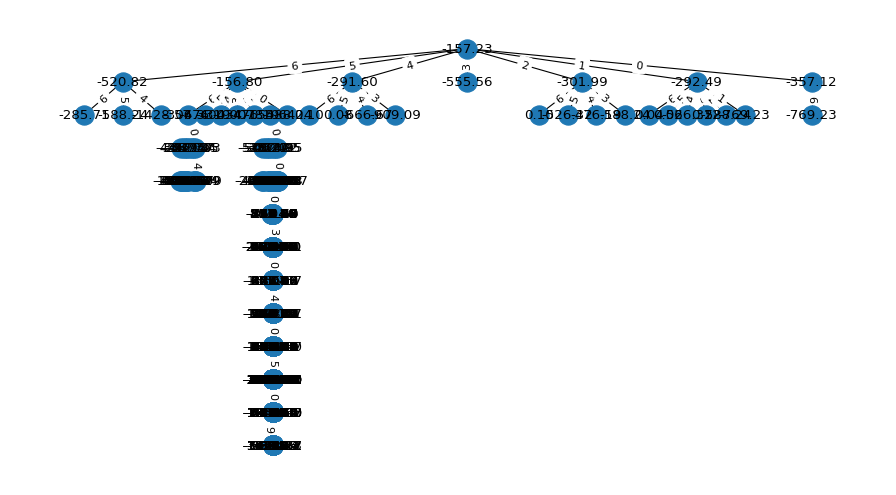

In [37]:
g = from_dict_of_dicts(child_dict)


plt.figure(figsize=(11, 6), dpi=80)
pos = hierarchy_pos(g, agent.root.parent, width=1)
node_labels = {node: f"{node.q/node.n:.2f}" for node in g.nodes}
edge_labels = {(node, child): action for node in g.nodes for action, child in node.children.items()}
draw(g, pos, labels=node_labels)
draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
plt.show()